# Fraud Detection using Machine Learning Classification Models

## Objective
This notebook implements an end-to-end machine learning pipeline for **fraud detection** in credit card transactions. We will:
1. Perform Exploratory Data Analysis (EDA)
2. Preprocess and clean the data
3. Handle imbalanced dataset
4. Train multiple classification models
5. Evaluate and compare model performance

## Dataset
- **Source**: Credit card transaction data
- **Target**: `isFraud` (0 = Legitimate, 1 = Fraudulent)
- **Challenge**: Highly imbalanced dataset (fraud is rare)

## 1. Import Required Libraries

In [47]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

np.random.seed(42)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Load and Explore the Dataset

In [48]:
# Load the training data
train_df = pd.read_csv('datasets/transaction/train_transaction.csv')

print("Dataset Shape:", train_df.shape)

Dataset Shape: (590540, 394)


In [49]:
print(train_df.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN  

In [50]:
print(train_df.isnull().sum())

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 394, dtype: int64


In [51]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB
None


In [52]:
print(train_df.describe())

       TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06      135.027176   
std     1.704744e+05       0.183755   4.617224e+06      239.162522   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.134635e+06       0.000000   3.027058e+06       43.321000   
50%     3.282270e+06       0.000000   7.306528e+06       68.769000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31937.391000   

               card1          card2          card3          card5  \
count  590540.000000  581607.000000  588975.000000  586281.000000   
mean     9898.734658     362.555488     153.194925     199.278897   
std      4901.170153     157.793246      11.336444      41.244453   
min      1000.000000     100.000000     100.000000     100.000000   
25%      6019.000000    

Class Distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64

Class Percentage:
isFraud
0    96.500999
1     3.499001
Name: proportion, dtype: float64


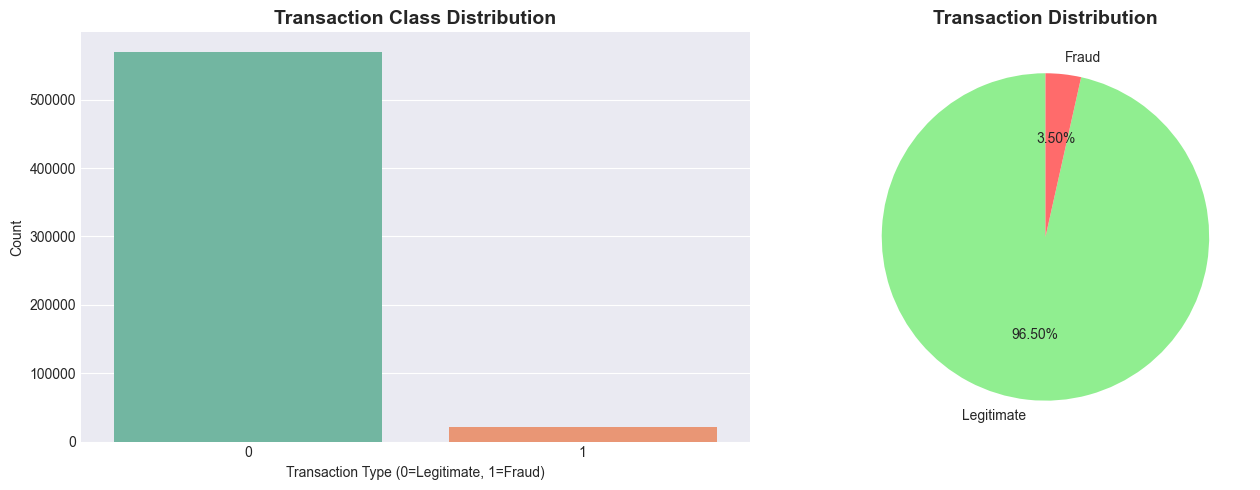

In [53]:
# Check class distribution (Fraud vs Non-Fraud)
print("Class Distribution:")
print(train_df['isFraud'].value_counts())
print("\nClass Percentage:")
print(train_df['isFraud'].value_counts(normalize=True) * 100)

# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=train_df, x='isFraud', ax=axes[0], palette='Set2')
axes[0].set_title('Transaction Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Transaction Type (0=Legitimate, 1=Fraud)')
axes[0].set_ylabel('Count')

# Pie chart
fraud_counts = train_df['isFraud'].value_counts()
axes[1].pie(fraud_counts, labels=['Legitimate', 'Fraud'], autopct='%1.2f%%', 
            startangle=90, colors=['#90EE90', '#FF6B6B'])
axes[1].set_title('Transaction Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

> 1. Terdapat 394 fitur <br>
> 2. Terdapat timpang jumlah kelas antara log transaksi asli dengan log transaksi palsu <br>
> 3. Banyak kelas dengan NaN value sehingga perlu pendekatan imputasi yang baik <br>

## 3. Exploratory Data Analysis (EDA)

Missing Values Analysis:
    Column  Missing_Count  Missing_Percentage
14   dist2         552913           93.628374
37      D7         551623           93.409930
43     D13         528588           89.509263
44     D14         528353           89.469469
42     D12         525823           89.041047
36      D6         517353           87.606767
39      D9         515614           87.312290
38      D8         515614           87.312290
211   V157         508595           86.123717
217   V163         508595           86.123717
216   V162         508595           86.123717
215   V161         508595           86.123717
212   V158         508595           86.123717
207   V153         508595           86.123717
192   V138         508595           86.123717
209   V155         508595           86.123717
208   V154         508595           86.123717
203   V149         508595           86.123717
202   V148         508595           86.123717
201   V147         508595           86.123717
    Colum

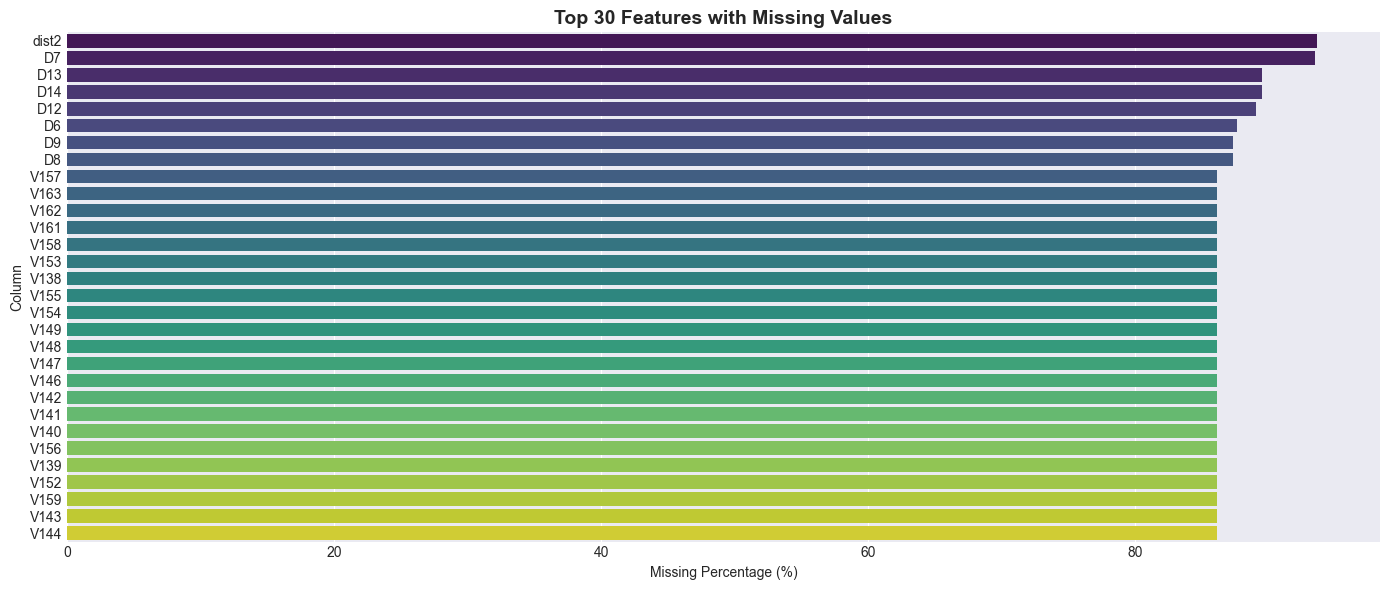

In [54]:
# Check missing values
print("Missing Values Analysis:")
missing = train_df.isnull().sum()
missing_percent = (missing / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
print(missing_df.head(20))

# Visualize missing data
plt.figure(figsize=(14, 6))
top_missing = missing_df.head(30)
sns.barplot(data=top_missing, y='Column', x='Missing_Percentage', palette='viridis')
plt.title('Top 30 Features with Missing Values', fontsize=14, fontweight='bold')
plt.xlabel('Missing Percentage (%)')
plt.tight_layout()
plt.show()

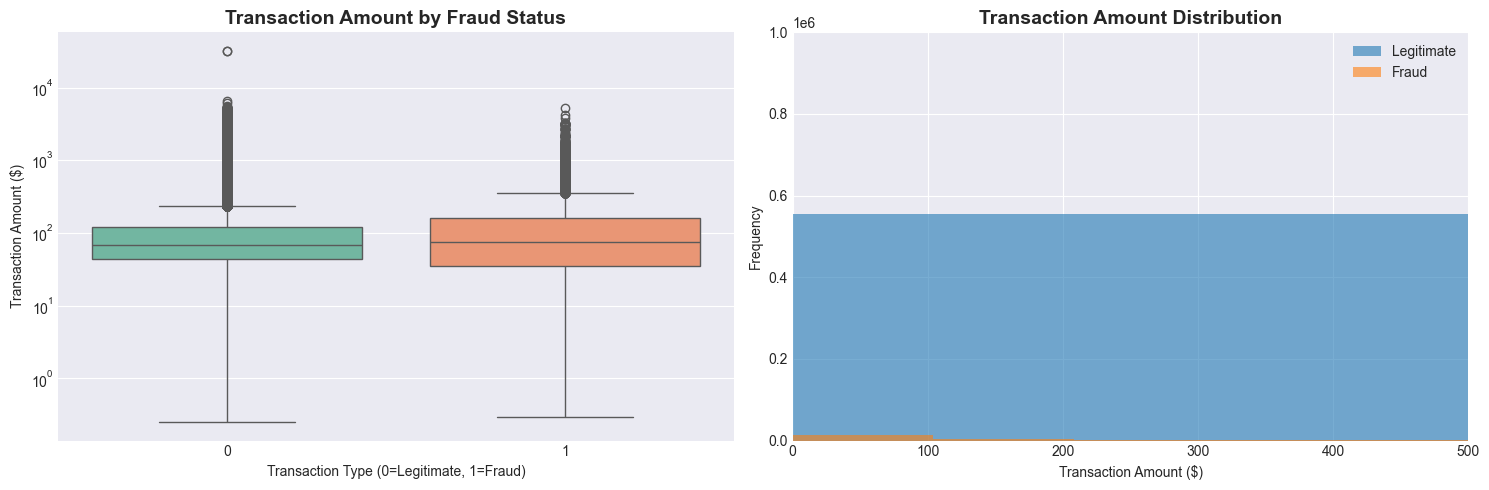


Transaction Amount Statistics by Fraud Status:
            count        mean         std    min     25%   50%    75%  \
isFraud                                                                 
0        569877.0  134.511665  239.395078  0.251  43.970  68.5  120.0   
1         20663.0  149.244779  232.212163  0.292  35.044  75.0  161.0   

               max  
isFraud             
0        31937.391  
1         5191.000  


In [55]:
# Analyze Transaction Amount by Fraud Status
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot
sns.boxplot(data=train_df, x='isFraud', y='TransactionAmt', ax=axes[0], palette='Set2')
axes[0].set_title('Transaction Amount by Fraud Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Transaction Type (0=Legitimate, 1=Fraud)')
axes[0].set_ylabel('Transaction Amount ($)')
axes[0].set_yscale('log')  # Log scale for better visualization

# Distribution plot
for fraud_type in [0, 1]:
    data = train_df[train_df['isFraud'] == fraud_type]['TransactionAmt']
    axes[1].hist(data, bins=50, alpha=0.6, label=f'{"Legitimate" if fraud_type == 0 else "Fraud"}')
axes[1].set_title('Transaction Amount Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Transaction Amount ($)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].set_xlim(0, 500)  # Focus on common range
axes[1].set_ylim(0, 1000000)  # Increase y-axis limit for better visibility

plt.tight_layout()
plt.show()

print("\nTransaction Amount Statistics by Fraud Status:")
print(train_df.groupby('isFraud')['TransactionAmt'].describe())

> Dari grafik kiri:<br>
> 1. Distribusi dan median dua kelas sama<br>
> 2. Banyak outliers di atas median pada dua kelas tersebut <br>
>
> Dari grafik kanan:<br>
> 1. Terdapat timpang jumlah kelas<br>
> 2. Grafik *skew* ke kiri, artinya banyak transaksi fraud yang <100$<br>

## 4. Data Preprocessing and Feature Engineering

In [56]:
# Create a working copy
df = train_df.copy()

# Drop TransactionID as it's just an identifier
df = df.drop('TransactionID', axis=1)

basic_features = ['isFraud', 'TransactionAmt', 'TransactionDT', 
                  'card1', 'card2', 'card3', 
                  'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

# Keep only these basic columns
df = df[basic_features]

print(f"Selected only {len(basic_features)-1} BASIC features for baseline model")
print(f"Features: {[col for col in basic_features if col != 'isFraud']}")
print(f"Dataset shape: {df.shape}")
print("✓ Simple feature selection complete")

Selected only 11 BASIC features for baseline model
Features: ['TransactionAmt', 'TransactionDT', 'card1', 'card2', 'card3', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
Dataset shape: (590540, 12)
✓ Simple feature selection complete


In [57]:
print(f"Missing values before: {df.isnull().sum().sum()}")

# Simple approach: fill missing values with median
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

print(f"Missing values after: {df.isnull().sum().sum()}")
print("✓ Missing values handled with median imputation")

# Separate features and target
X = df.drop('isFraud', axis=1)
y = df['isFraud']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"Fraud percentage: {(y.sum() / len(y) * 100):.2f}%")

Missing values before: 10498
Missing values after: 0
✓ Missing values handled with median imputation

Feature matrix shape: (590540, 11)
Target vector shape: (590540,)

Class distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64
Fraud percentage: 3.50%


In [58]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"\nClass distribution in training:")
print(y_train.value_counts())

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data split and scaled successfully")

Training set: (472432, 11)
Testing set: (118108, 11)

Class distribution in training:
isFraud
0    455902
1     16530
Name: count, dtype: int64

✓ Data split and scaled successfully


## 5. Model Training and Evaluation

We will train and evaluate the following classification models:
1. **Logistic Regression** - Simple linear baseline
2. **Random Forest Classifier** - Ensemble of decision trees
3. **Gradient Boosting Classifier** - Boosting algorithm (sklearn version)

In [59]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a classification model
    """
    print(f"\n{'='*80}")
    print(f"Training {name}...")
    print('='*80)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n📊 Performance Metrics:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"   ROC-AUC:   {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    axes[0].set_title(f'{name} - Confusion Matrix', fontweight='bold')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')
    
    # ROC Curve
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        axes[1].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})', linewidth=2)
        axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title(f'{name} - ROC Curve', fontweight='bold')
        axes[1].legend()
        axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))
    
    return {
        'model': name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc if y_pred_proba is not None else None
    }

print("✓ Evaluation function defined")

✓ Evaluation function defined


### 5.1 Logistic Regression


Training Logistic Regression (Baseline)...

📊 Performance Metrics:
   Accuracy:  0.8504
   Precision: 0.1049
   Recall:    0.4348
   F1-Score:  0.1690
   ROC-AUC:   0.7021

📊 Performance Metrics:
   Accuracy:  0.8504
   Precision: 0.1049
   Recall:    0.4348
   F1-Score:  0.1690
   ROC-AUC:   0.7021


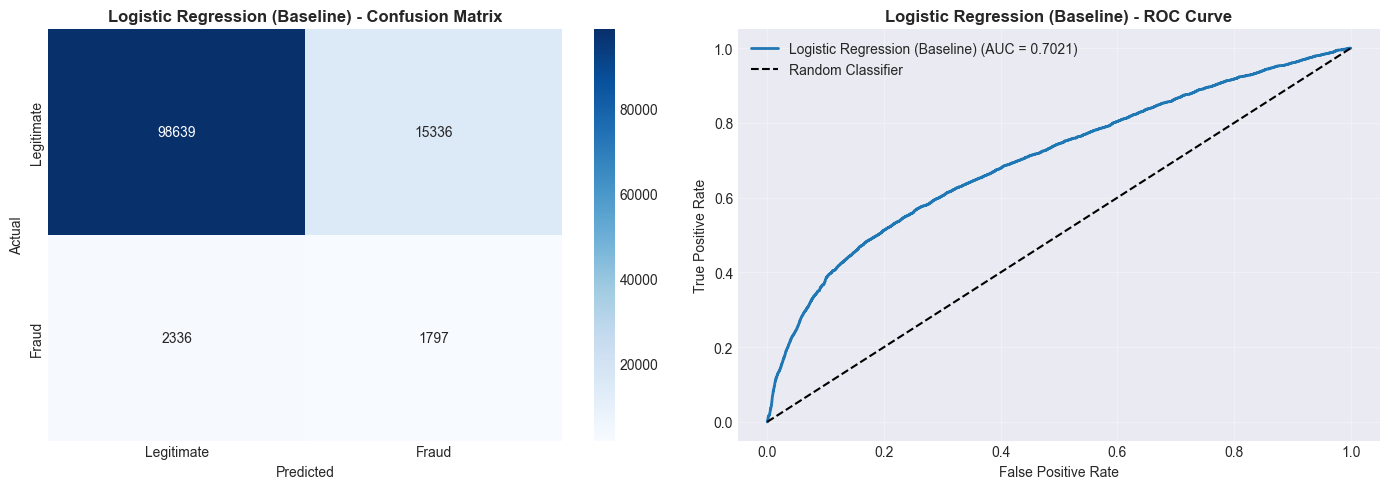


📋 Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.98      0.87      0.92    113975
       Fraud       0.10      0.43      0.17      4133

    accuracy                           0.85    118108
   macro avg       0.54      0.65      0.54    118108
weighted avg       0.95      0.85      0.89    118108



In [60]:
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_results = evaluate_model('Logistic Regression (Baseline)', lr_model, 
                             X_train_scaled, y_train, 
                             X_test_scaled, y_test)

### 5.2 Random Forest Classifier


Training Random Forest...

📊 Performance Metrics:
   Accuracy:  0.8570
   Precision: 0.1575
   Recall:    0.7099
   F1-Score:  0.2578
   ROC-AUC:   0.8723

📊 Performance Metrics:
   Accuracy:  0.8570
   Precision: 0.1575
   Recall:    0.7099
   F1-Score:  0.2578
   ROC-AUC:   0.8723


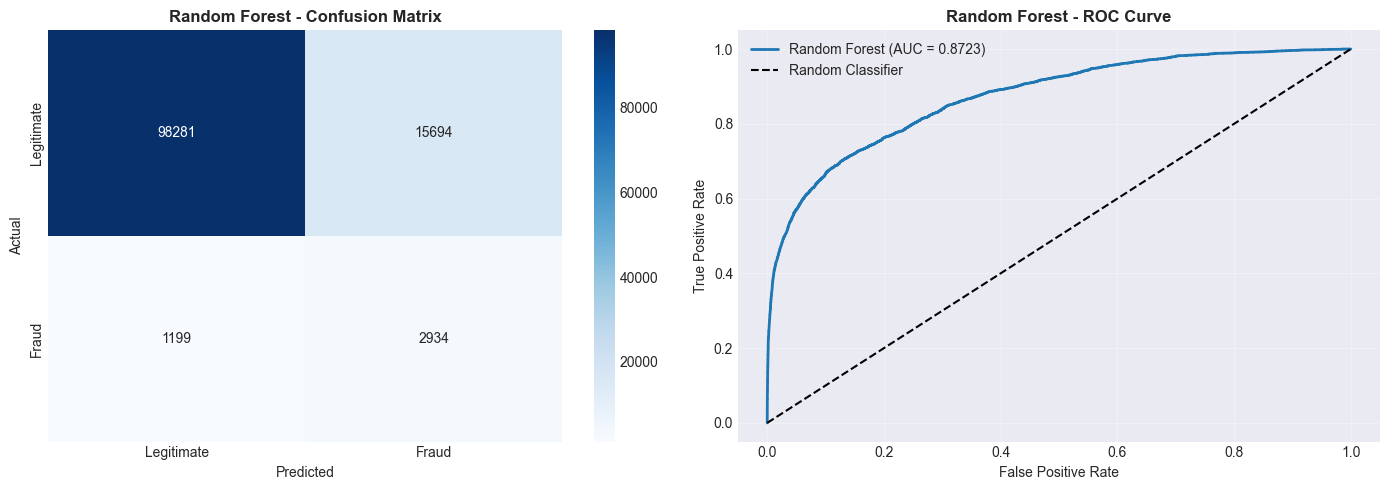


📋 Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      0.86      0.92    113975
       Fraud       0.16      0.71      0.26      4133

    accuracy                           0.86    118108
   macro avg       0.57      0.79      0.59    118108
weighted avg       0.96      0.86      0.90    118108



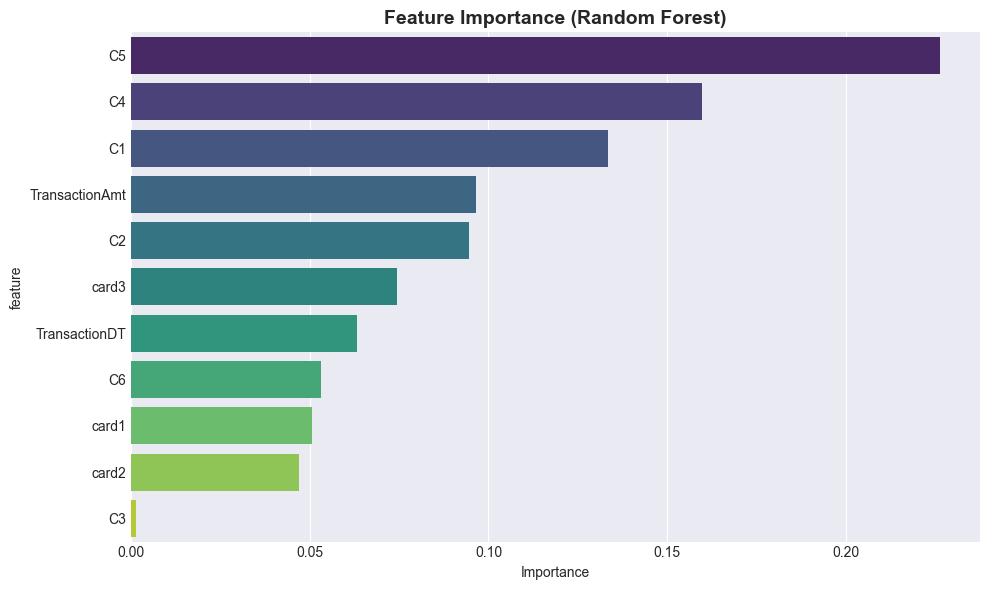


Top Features:
           feature  importance
9               C5    0.226241
8               C4    0.159796
5               C1    0.133358
0   TransactionAmt    0.096503
6               C2    0.094547
4            card3    0.074417
1    TransactionDT    0.063092
10              C6    0.053087
2            card1    0.050606
3            card2    0.046944
7               C3    0.001408


In [61]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, 
                                  n_jobs=-1, class_weight='balanced')
rf_results = evaluate_model('Random Forest', rf_model,
                            X_train_scaled, y_train,
                            X_test_scaled, y_test)

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\nTop Features:")
print(feature_importance)

### 5.3 Gradient Boosting Classifier


Training Gradient Boosting...

📊 Performance Metrics:
   Accuracy:  0.9712
   Precision: 0.8008
   Recall:    0.2364
   F1-Score:  0.3650
   ROC-AUC:   0.8467

📊 Performance Metrics:
   Accuracy:  0.9712
   Precision: 0.8008
   Recall:    0.2364
   F1-Score:  0.3650
   ROC-AUC:   0.8467


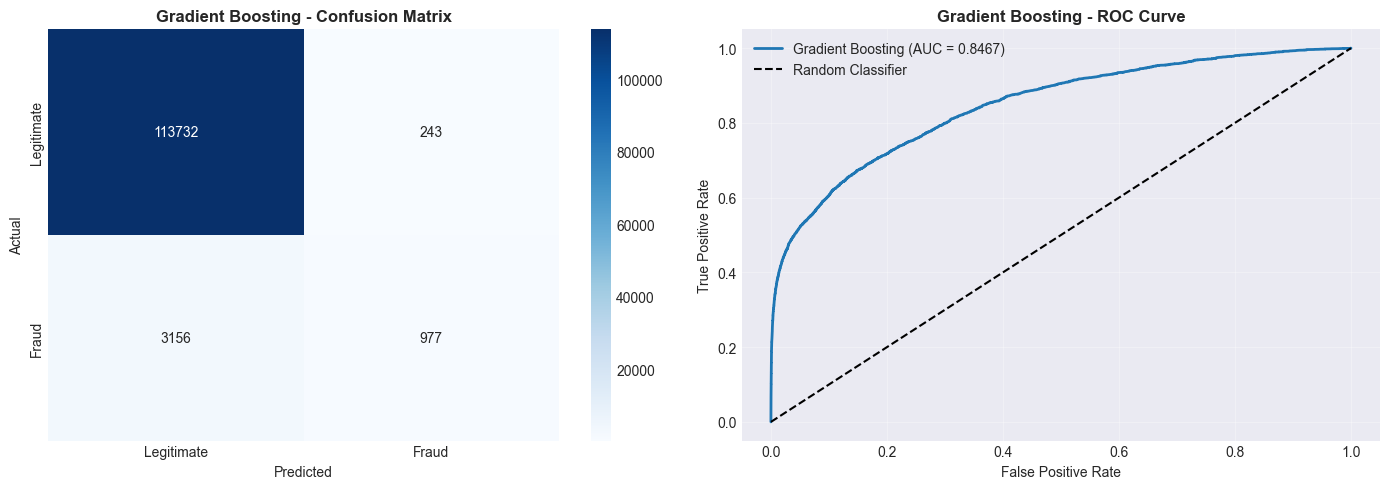


📋 Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.97      1.00      0.99    113975
       Fraud       0.80      0.24      0.37      4133

    accuracy                           0.97    118108
   macro avg       0.89      0.62      0.68    118108
weighted avg       0.97      0.97      0.96    118108



In [62]:
gb_model = GradientBoostingClassifier(n_estimators=50, max_depth=5, learning_rate=0.1, random_state=42)
gb_results = evaluate_model('Gradient Boosting', gb_model,
                            X_train_scaled, y_train,
                            X_test_scaled, y_test)

> Dari hasil *training* model, kita dapat menarik hasil:<br>
> ### Logistic Regression:<br>
> 1. Model memiliki hasil evaluasi dengan nilai terendah di semua metriks<br>
> 2. *Logistic Regression* terlalu simpel untuk menangkap seluruh fitur dari dataset 'train_transaction.csv'<br>
> ### Kesimpulan:<br>
> Model didefinisikan secara simpel dan kalah, maka kita tidak akan menggunakan model ini<br>

> ### Random Forest Classifier (RFC):<br>
> 1. Model terbaik dalam mendeteksi fraud (Recall 71%, artinya 7 dari 10 fraud tertangkap), tetapi dengan nilai recall yang rendah<br>
> 2. Nilai recall yang rendah berarti banyak *false alarm* dalam mendeteksi fraud<br>
> ### Kesimpulan:<br>
> Model dapat dikembangkan dengan hasil evaluasi ini<br>

> ### Gradient Boosting:<br>
> 1. Model memiliki akurasi dan presisi tertinggi, tetapi recall tetap tergolong rendah<br>
> 2. *Gradient Boosting* juga mengalami *false alarm*<br>
> ### Kesimpulan:<br>
> Model dapat dikembangkan dengan hasil evaluasi ini<br>

## 6. Model Comparison and Final Results

MODEL PERFORMANCE COMPARISON
                         model  accuracy  precision  recall  f1_score  roc_auc
Logistic Regression (Baseline)    0.8504     0.1049  0.4348    0.1690   0.7021
                 Random Forest    0.8570     0.1575  0.7099    0.2578   0.8723
             Gradient Boosting    0.9712     0.8008  0.2364    0.3650   0.8467


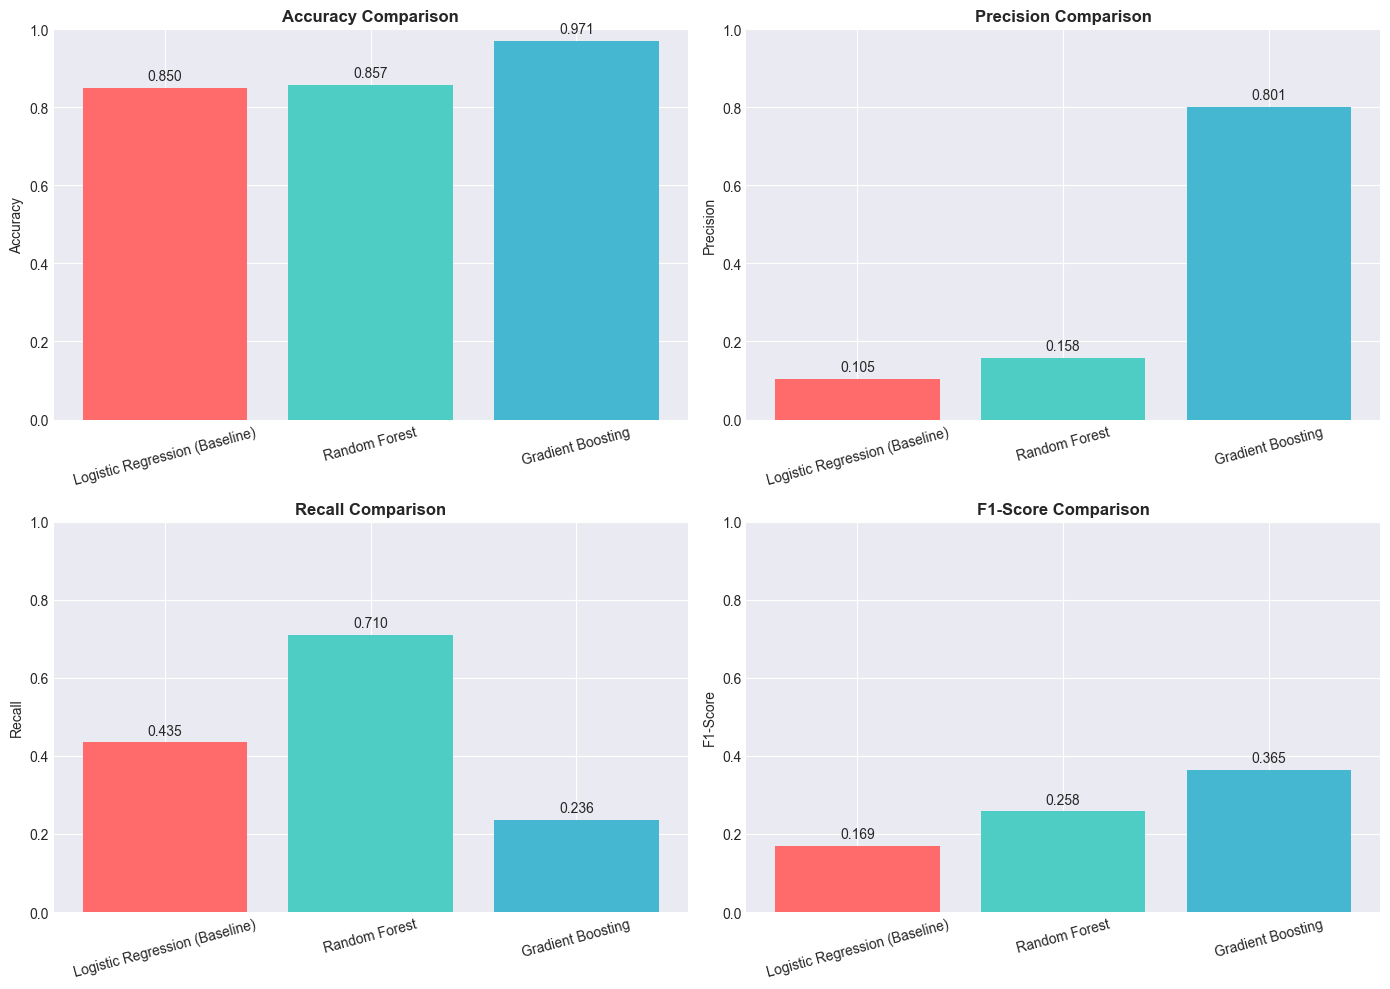

In [63]:
# Compile all results
results_df = pd.DataFrame([lr_results, rf_results, gb_results])
results_df = results_df.round(4)

print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axes[0, 0].bar(results_df['model'], results_df['accuracy'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].tick_params(axis='x', rotation=15)
for i, v in enumerate(results_df['accuracy']):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

# Precision
axes[0, 1].bar(results_df['model'], results_df['precision'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 1].set_title('Precision Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].tick_params(axis='x', rotation=15)
for i, v in enumerate(results_df['precision']):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

# Recall
axes[1, 0].bar(results_df['model'], results_df['recall'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1, 0].set_title('Recall Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].tick_params(axis='x', rotation=15)
for i, v in enumerate(results_df['recall']):
    axes[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

# F1-Score
axes[1, 1].bar(results_df['model'], results_df['f1_score'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1, 1].set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].tick_params(axis='x', rotation=15)
for i, v in enumerate(results_df['f1_score']):
    axes[1, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [64]:
# Identify the best model
best_model_idx = results_df['f1_score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'model']
best_f1 = results_df.loc[best_model_idx, 'f1_score']
best_roc_auc = results_df.loc[best_model_idx, 'roc_auc']

print(f"Best Model: {best_model_name}")
print(f"F1-Score: {best_f1:.4f}")
print(f"ROC-AUC Score: {best_roc_auc:.4f}")

Best Model: Gradient Boosting
F1-Score: 0.3650
ROC-AUC Score: 0.8467


## 7. Improvements on Model
> We will ditch *Logistic Regression*. We will move on with Random Forest Classifier and Gradient Boosting

## 7.1 Improvements on Random Forest Classifier

In [65]:
print("Adding more features to Random Forest model...")

enhanced_features = ['isFraud', 'TransactionAmt', 'TransactionDT', 
                     'ProductCD',  # Categorical - product type
                     'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                     'addr1', 'addr2',  # Address info
                     'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
                     'C11', 'C12', 'C13', 'C14',  # Count features
                     'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D15',  # Time deltas
                     'M1', 'M2', 'M3', 'M4', 'M5', 'M6']  # Match features

# Filter columns that exist
enhanced_features = [col for col in enhanced_features if col in train_df.columns]
df_enhanced = train_df[enhanced_features].copy()

print(f"Original features: 11")
print(f"Enhanced features: {len(enhanced_features)-1}")
print(f"Added: {len(enhanced_features)-1 - 11} new features")

# Handle categorical columns
categorical_cols = df_enhanced.select_dtypes(include=['object']).columns.tolist()
if 'isFraud' in categorical_cols:
    categorical_cols.remove('isFraud')

print(f"\nEncoding {len(categorical_cols)} categorical columns: {categorical_cols}")

for col in categorical_cols:
    le = LabelEncoder()
    df_enhanced[col] = le.fit_transform(df_enhanced[col].astype(str))

# Handle missing values
print(f"\nHandling missing values...")
print(f"Missing before: {df_enhanced.isnull().sum().sum()}")

for col in df_enhanced.columns:
    if df_enhanced[col].isnull().sum() > 0:
        df_enhanced[col].fillna(df_enhanced[col].median(), inplace=True)

print(f"Missing after: {df_enhanced.isnull().sum().sum()}")

# Separate features and target
X_enhanced = df_enhanced.drop('isFraud', axis=1)
y_enhanced = df_enhanced['isFraud']

# Split data
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42, stratify=y_enhanced
)

# Scale features
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

print(f"\n✅ Enhanced dataset ready!")
print(f"   Training shape: {X_train_enh_scaled.shape}")
print(f"   Testing shape: {X_test_enh_scaled.shape}")

Adding more features to Random Forest model...
Original features: 11
Enhanced features: 38
Added: 27 new features

Encoding 9 categorical columns: ['ProductCD', 'card4', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6']

Handling missing values...
Missing before: 1335011

Handling missing values...
Missing before: 1335011
Missing after: 0
Missing after: 0

✅ Enhanced dataset ready!
   Training shape: (472432, 38)
   Testing shape: (118108, 38)

✅ Enhanced dataset ready!
   Training shape: (472432, 38)
   Testing shape: (118108, 38)


Training Enhanced Random Forest Classifier


Training Random Forest (Enhanced Features)...

📊 Performance Metrics:
   Accuracy:  0.9477
   Precision: 0.3734
   Recall:    0.7290
   F1-Score:  0.4939
   ROC-AUC:   0.9340

📊 Performance Metrics:
   Accuracy:  0.9477
   Precision: 0.3734
   Recall:    0.7290
   F1-Score:  0.4939
   ROC-AUC:   0.9340


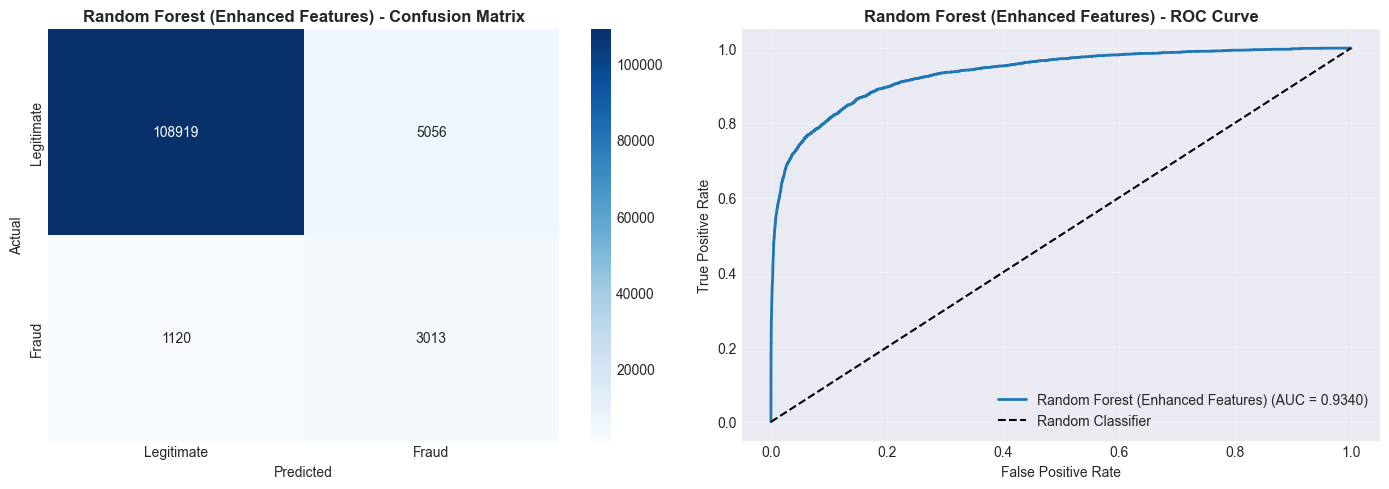


📋 Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      0.96      0.97    113975
       Fraud       0.37      0.73      0.49      4133

    accuracy                           0.95    118108
   macro avg       0.68      0.84      0.73    118108
weighted avg       0.97      0.95      0.96    118108



In [66]:
rf_enhanced = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15,  # Slightly deeper for more features
    random_state=42, 
    n_jobs=-1, 
    class_weight='balanced'
)

rf_enhanced_results = evaluate_model(
    'Random Forest (Enhanced Features)', 
    rf_enhanced,
    X_train_enh_scaled, y_train_enh,
    X_test_enh_scaled, y_test_enh
)

Comparing Baseline Random Forest Classifier with Improved Random Forest Classifier

In [67]:
comparison_df = pd.DataFrame([rf_results, rf_enhanced_results])
comparison_df['improvement'] = comparison_df.apply(
    lambda row: 'Enhanced' if row.name == 1 else 'Baseline', axis=1
)

print(comparison_df[['improvement', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].to_string(index=False))

# Calculate improvements
print("\nImprovements:")
for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']:
    baseline = rf_results[metric]
    enhanced = rf_enhanced_results[metric]
    diff = enhanced - baseline
    pct = (diff / baseline) * 100 if baseline > 0 else 0
    print(f"   {metric.capitalize():15s}: {baseline:.4f} → {enhanced:.4f} ({diff:+.4f}, {pct:+.1f}%)")

improvement  accuracy  precision   recall  f1_score  roc_auc
   Baseline  0.856970   0.157505 0.709896  0.257809 0.872272
   Enhanced  0.947709   0.373404 0.729010  0.493853 0.934024

Improvements:
   Accuracy       : 0.8570 → 0.9477 (+0.0907, +10.6%)
   Precision      : 0.1575 → 0.3734 (+0.2159, +137.1%)
   Recall         : 0.7099 → 0.7290 (+0.0191, +2.7%)
   F1_score       : 0.2578 → 0.4939 (+0.2360, +91.6%)
   Roc_auc        : 0.8723 → 0.9340 (+0.0618, +7.1%)


Top Features

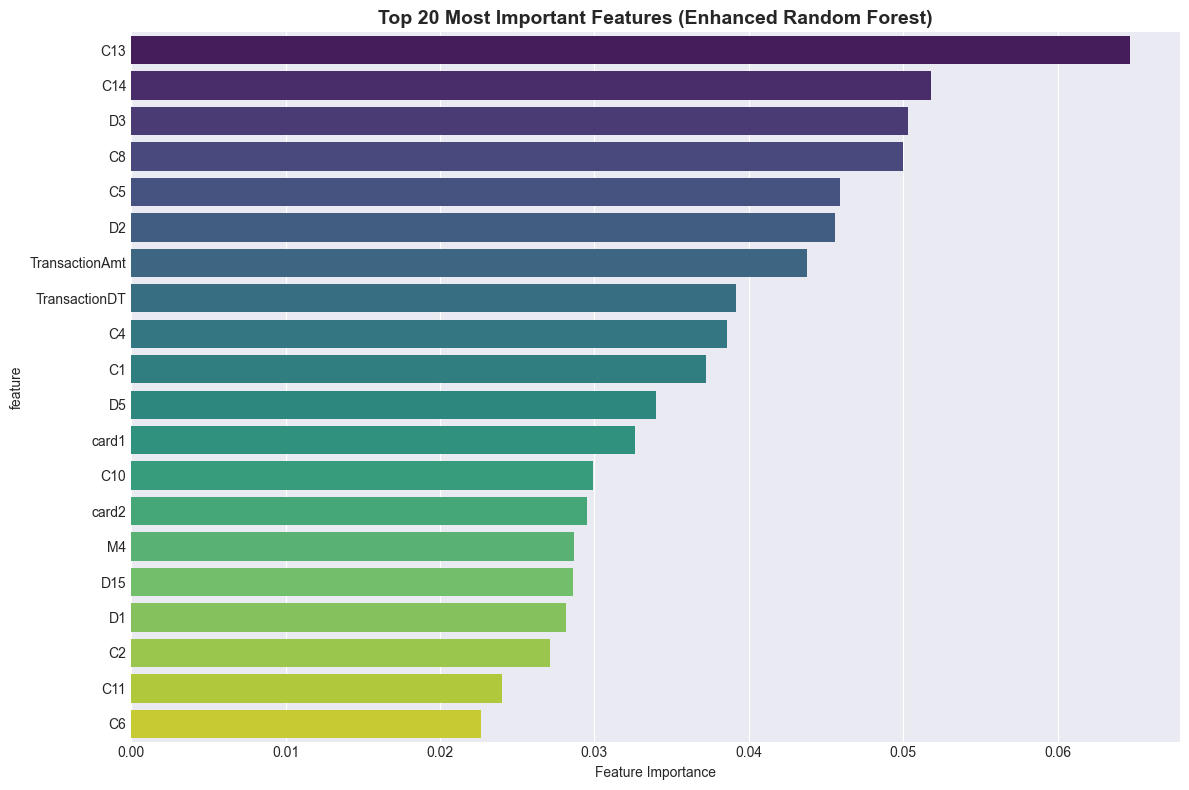


Top 10 Features:
       feature  importance
           C13    0.064690
           C14    0.051794
            D3    0.050337
            C8    0.050013
            C5    0.045909
            D2    0.045598
TransactionAmt    0.043769
 TransactionDT    0.039199
            C4    0.038576
            C1    0.037208


In [68]:
feature_importance_enh = pd.DataFrame({
    'feature': X_enhanced.columns,
    'importance': rf_enhanced.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_enh.head(20), x='importance', y='feature', palette='viridis')
plt.title('Top 20 Most Important Features (Enhanced Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(feature_importance_enh.head(10).to_string(index=False))

> 1.Model diperbaiki dengan menambahkan jumlah fitur yang dapat dimuat. Penambahan fitur ini membuat model memiliki "*bigger pciture*" untuk mendeteksi fraud<br>
> 2.Model juga memiliki balance yang lebih baik antara *precision* dengan *recall*<br>

## Applying SMOTE to Random Forest Classifier

In [69]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Applying SMOTE

In [70]:
from imblearn.over_sampling import SMOTE
print(y_train_enh.value_counts())

isFraud
0    455902
1     16530
Name: count, dtype: int64


In [71]:
smote = SMOTE(random_state=42, sampling_strategy=0.2)
X_train_smote, y_train_smote = smote.fit_resample(X_train_enh_scaled, y_train_enh)

print("\n📊 Class Distribution AFTER SMOTE:")
print(pd.Series(y_train_smote).value_counts())
print(f"\nFraud percentage: {(y_train_smote.sum() / len(y_train_smote) * 100):.2f}%")

print(f"\n✅ SMOTE Applied Successfully!")
print(f"   Original training samples: {len(y_train_enh)}")
print(f"   After SMOTE: {len(y_train_smote)}")
print(f"   Synthetic fraud samples generated: {len(y_train_smote) - len(y_train_enh)}")


📊 Class Distribution AFTER SMOTE:
isFraud
0    455902
1     91180
Name: count, dtype: int64

Fraud percentage: 16.67%

✅ SMOTE Applied Successfully!
   Original training samples: 472432
   After SMOTE: 547082
   Synthetic fraud samples generated: 74650


Train Random Forest Classifier with SMOTEd Data


Training Random Forest (Enhanced + SMOTE)...

📊 Performance Metrics:
   Accuracy:  0.9796
   Precision: 0.8657
   Recall:    0.4929
   F1-Score:  0.6281
   ROC-AUC:   0.9205

📊 Performance Metrics:
   Accuracy:  0.9796
   Precision: 0.8657
   Recall:    0.4929
   F1-Score:  0.6281
   ROC-AUC:   0.9205


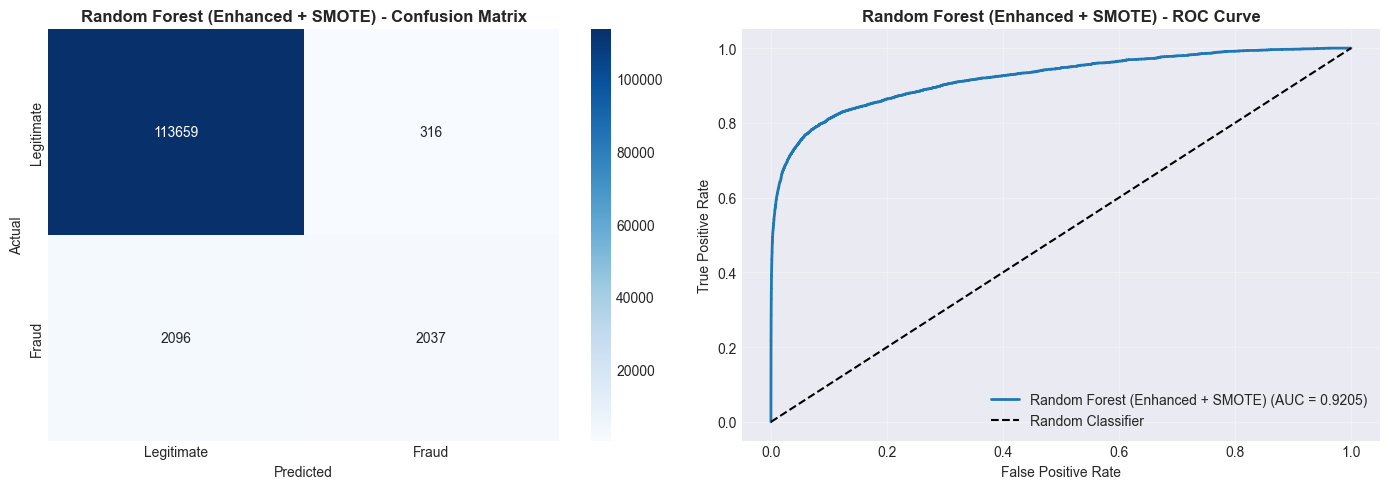


📋 Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.98      1.00      0.99    113975
       Fraud       0.87      0.49      0.63      4133

    accuracy                           0.98    118108
   macro avg       0.92      0.75      0.81    118108
weighted avg       0.98      0.98      0.98    118108



In [72]:
rf_smote = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15,
    random_state=42, 
    n_jobs=-1,
    # NOTE: No need for class_weight='balanced' anymore, SMOTE handled it!
)

rf_smote_results = evaluate_model(
    'Random Forest (Enhanced + SMOTE)', 
    rf_smote,
    X_train_smote, y_train_smote,  # Use SMOTE data
    X_test_enh_scaled, y_test_enh   # Test on original (real) data
)

Comparison


                            model  accuracy  precision   recall  f1_score  roc_auc
                    Random Forest  0.856970   0.157505 0.709896  0.257809 0.872272
Random Forest (Enhanced Features)  0.947709   0.373404 0.729010  0.493853 0.934024
 Random Forest (Enhanced + SMOTE)  0.979578   0.865703 0.492862  0.628122 0.920527


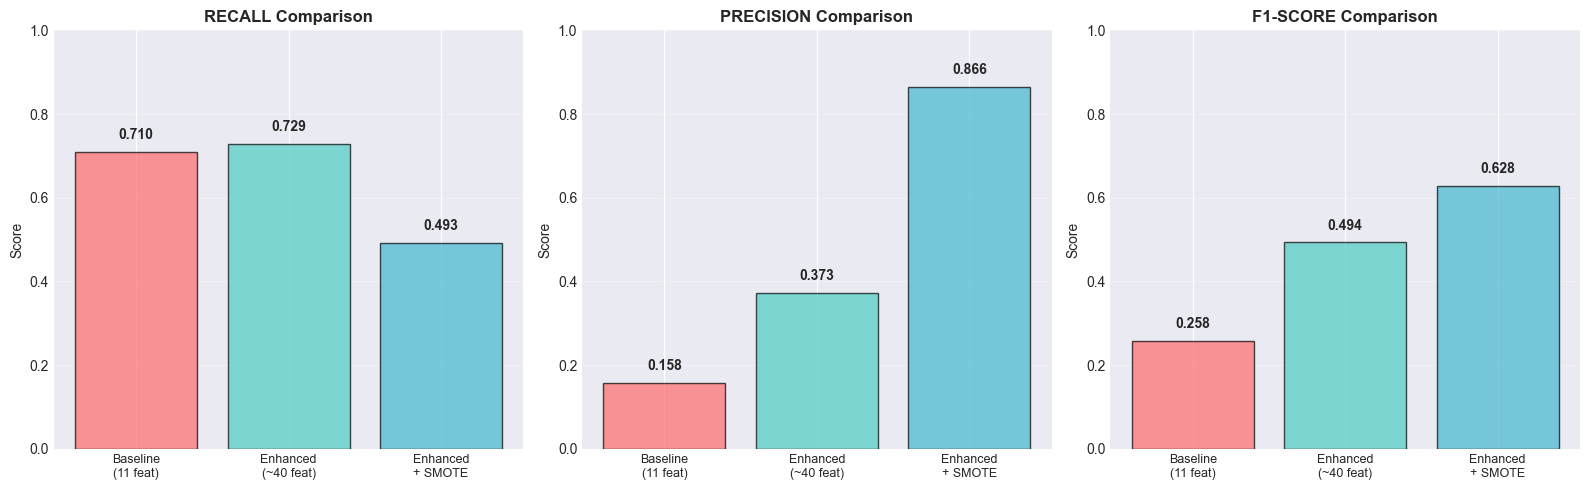

Metric            Baseline   Enhanced    + SMOTE   Final Gain
Accuracy            0.8570     0.9477     0.9796        14.3%
Precision           0.1575     0.3734     0.8657       449.6%
Recall              0.7099     0.7290     0.4929       -30.6%
F1_score            0.2578     0.4939     0.6281       143.6%
Roc_auc             0.8723     0.9340     0.9205         5.5%


In [73]:
comparison_all = pd.DataFrame([
    rf_results,              # Baseline (11 features)
    rf_enhanced_results,     # Enhanced features
    rf_smote_results         # Enhanced + SMOTE
])

print("\n" + comparison_all.to_string(index=False))

# Visualize improvements
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['recall', 'precision', 'f1_score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
labels = ['Baseline\n(11 feat)', 'Enhanced\n(~40 feat)', 'Enhanced\n+ SMOTE']

for idx, metric in enumerate(metrics):
    values = comparison_all[metric].values
    bars = axes[idx].bar(range(3), values, color=colors, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{metric.upper().replace("_", "-")} Comparison', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xticks(range(3))
    axes[idx].set_xticklabels(labels, fontsize=9)
    axes[idx].set_ylim(0, 1)
    axes[idx].set_ylabel('Score')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, values)):
        axes[idx].text(i, val + 0.03, f'{val:.3f}', 
                      ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"{'Metric':<15} {'Baseline':>10} {'Enhanced':>10} {'+ SMOTE':>10} {'Final Gain':>12}")

for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']:
    baseline = rf_results[metric]
    enhanced = rf_enhanced_results[metric]
    smote = rf_smote_results[metric]
    gain = ((smote - baseline) / baseline * 100) if baseline > 0 else 0
    
    print(f"{metric.capitalize():<15} {baseline:>10.4f} {enhanced:>10.4f} {smote:>10.4f} {gain:>11.1f}%")

> Model mengalami *trade-off* ketika kita mengimplementasikan SMOTE (nilai sampling 0.5 dan 0.2)<br>
> 1. SMOTE menaikkan nilai precision secara drastis (+36.0% hingga 49.2%)<br>
> 2. SMOTE menurunkan nilai recall (-16.0% hingga 23.6%)

> *Trade-off* yang terjadi tidak ***worth it*** untuk dataset ini karena model dapat mengalami overfit<br>
> Sampel pada dataset ini kurang representatif, *fraud* di *real-world* lebih varied sehingga **model dengan SMOTE tidak akan dipakai** <br>

## Hyperparameter Tuning for Enhanced Random Forest (Without SMOTE)

In [74]:
from sklearn.model_selection import GridSearchCV


# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

print("\nParameter Grid:")
for param, values in param_grid.items():
    print(f"   {param}: {values}")

total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations to test: {total_combinations}")
print(f"   With 3-fold CV: {total_combinations * 3} model fits")

# Initialize Random Forest with class_weight='balanced'
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Setup GridSearchCV with recall scoring
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='recall',  # Optimize for recall
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\nGridSearchCV configured successfully!")
print("   Starting hyperparameter search...")


Parameter Grid:
   n_estimators: [100, 200]
   max_depth: [15, 20, 25]
   min_samples_split: [2, 5]
   min_samples_leaf: [1, 2]
   max_features: ['sqrt', 'log2']

Total combinations to test: 48
   With 3-fold CV: 144 model fits

GridSearchCV configured successfully!
   Starting hyperparameter search...


Fit GridSearchCV (This may take several minutes...)

In [ ]:
import time

start_time = time.time()

# Fit GridSearchCV
grid_search.fit(X_train_enh_scaled, y_train_enh)

elapsed_time = time.time() - start_time

print(f"\nGridSearchCV completed in {elapsed_time/60:.2f} minutes!")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\nBest Cross-Validation Recall Score: {grid_search.best_score_:.4f}")

# Get the best model
rf_tuned = grid_search.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


Evaluate Tuned Random Forest Model


Training Random Forest (Hyperparameter Tuned)...

📊 Performance Metrics:
   Accuracy:  0.9449
   Precision: 0.3601
   Recall:    0.7394
   F1-Score:  0.4843
   ROC-AUC:   0.9331

📊 Performance Metrics:
   Accuracy:  0.9449
   Precision: 0.3601
   Recall:    0.7394
   F1-Score:  0.4843
   ROC-AUC:   0.9331


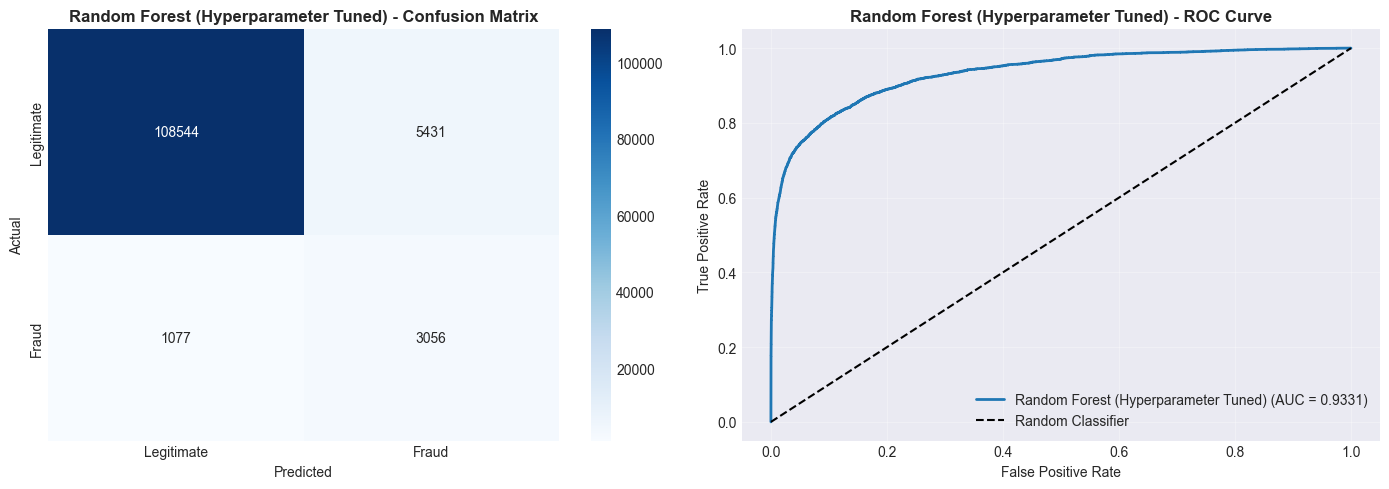


📋 Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      0.95      0.97    113975
       Fraud       0.36      0.74      0.48      4133

    accuracy                           0.94    118108
   macro avg       0.68      0.85      0.73    118108
weighted avg       0.97      0.94      0.95    118108



In [ ]:
rf_tuned_results = evaluate_model(
    'Random Forest (Hyperparameter Tuned)', 
    rf_tuned,
    X_train_enh_scaled, y_train_enh,
    X_test_enh_scaled, y_test_enh
)

Compare All Random Forest Versions


RANDOM FOREST MODEL EVOLUTION COMPARISON
                               model  accuracy  precision   recall  f1_score  roc_auc
                       Random Forest  0.856970   0.157505 0.709896  0.257809 0.872272
   Random Forest (Enhanced Features)  0.947709   0.373404 0.729010  0.493853 0.934024
Random Forest (Hyperparameter Tuned)  0.944898   0.360080 0.739414  0.484311 0.933075


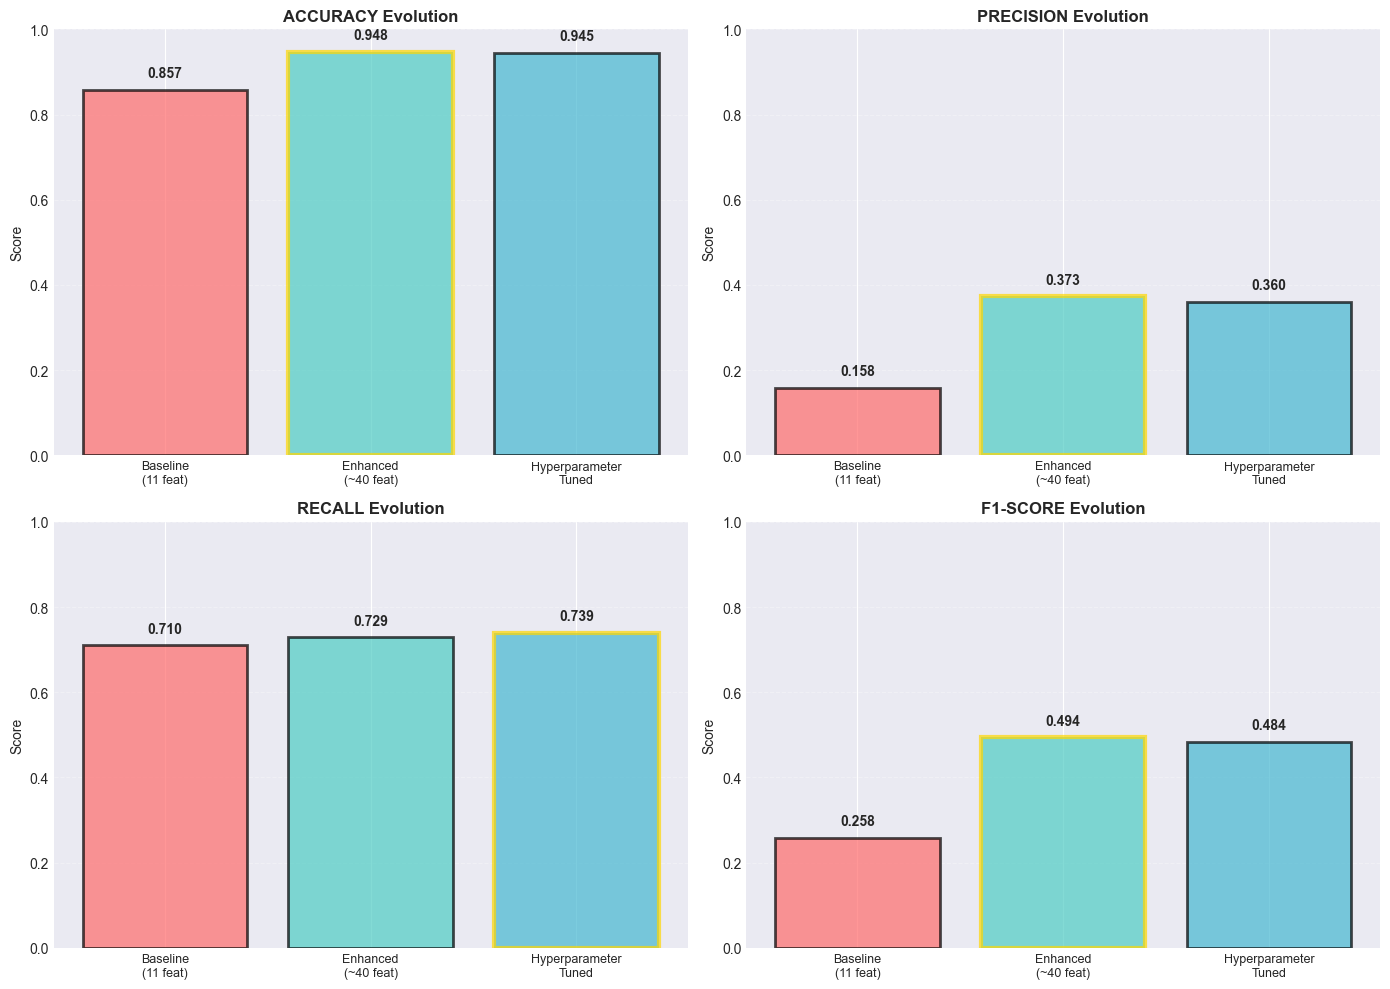


Metric            Baseline   Enhanced      Tuned   Total Gain
--------------------------------------------------------------
Accuracy            0.8570     0.9477     0.9449        10.3%
Precision           0.1575     0.3734     0.3601       128.6%
Recall              0.7099     0.7290     0.7394         4.2%
F1_score            0.2578     0.4939     0.4843        87.9%
Roc_auc             0.8723     0.9340     0.9331         7.0%


In [ ]:
# Compare all Random Forest versions
rf_comparison = pd.DataFrame([
    rf_results,              # Baseline (11 features)
    rf_enhanced_results,     # Enhanced features (~40)
    rf_tuned_results         # Hyperparameter tuned
])

print("\n" + "="*90)
print("RANDOM FOREST MODEL EVOLUTION COMPARISON")
print("="*90)
print(rf_comparison.to_string(index=False))
print("="*90)

# Visualize the progression
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
labels = ['Baseline\n(11 feat)', 'Enhanced\n(~40 feat)', 'Hyperparameter\nTuned']

for idx, metric in enumerate(metrics):
    row, col = idx // 2, idx % 2
    values = rf_comparison[metric].values
    bars = axes[row, col].bar(range(3), values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    axes[row, col].set_title(f'{metric.upper().replace("_", "-")} Evolution', 
                            fontsize=12, fontweight='bold')
    axes[row, col].set_xticks(range(3))
    axes[row, col].set_xticklabels(labels, fontsize=9)
    axes[row, col].set_ylim(0, 1)
    axes[row, col].set_ylabel('Score', fontsize=10)
    axes[row, col].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, values)):
        axes[row, col].text(i, val + 0.03, f'{val:.3f}', 
                           ha='center', fontsize=10, fontweight='bold')
    
    # Highlight best score
    best_idx = values.argmax()
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)

plt.tight_layout()
plt.show()

# Calculate improvements from baseline to tuned
print(f"\n{'Metric':<15} {'Baseline':>10} {'Enhanced':>10} {'Tuned':>10} {'Total Gain':>12}")
print("-" * 62)

for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']:
    baseline = rf_results[metric]
    enhanced = rf_enhanced_results[metric]
    tuned = rf_tuned_results[metric]
    gain = ((tuned - baseline) / baseline * 100) if baseline > 0 else 0
    
    print(f"{metric.capitalize():<15} {baseline:>10.4f} {enhanced:>10.4f} {tuned:>10.4f} {gain:>11.1f}%")

Top Features from Tuned Model

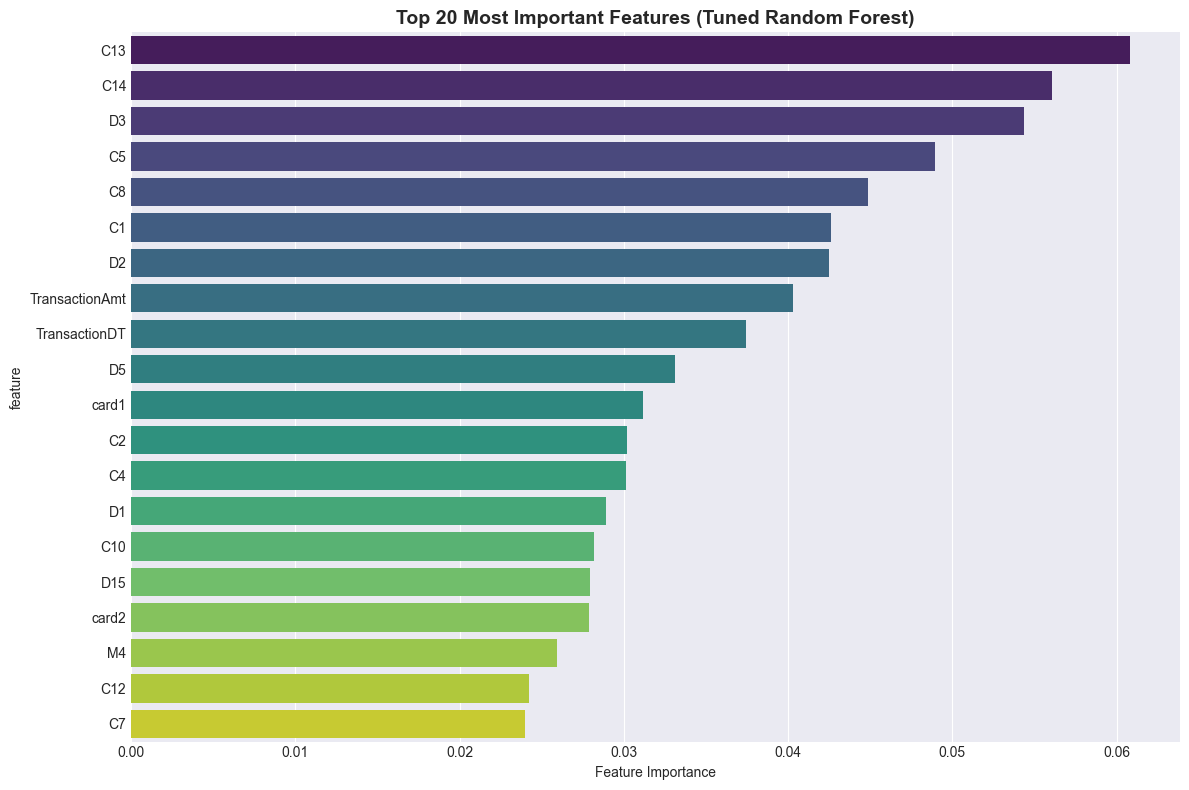


Top 10 Most Important Features:
       feature  importance
           C13    0.060823
           C14    0.056090
            D3    0.054377
            C5    0.048941
            C8    0.044838
            C1    0.042644
            D2    0.042477
TransactionAmt    0.040297
 TransactionDT    0.037433
            D5    0.033129


In [ ]:
feature_importance_tuned = pd.DataFrame({
    'feature': X_enhanced.columns,
    'importance': rf_tuned.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_tuned.head(20), x='importance', y='feature', palette='viridis')
plt.title('Top 20 Most Important Features (Tuned Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance_tuned.head(10).to_string(index=False))

GridSearchCV Results Analysis


Top 10 Parameter Combinations (by Recall):
 rank_test_score  mean_test_score  std_test_score  param_n_estimators  param_max_depth  param_min_samples_split  param_min_samples_leaf param_max_features
               1         0.695523        0.004010                 100               15                        5                       2               log2
               2         0.694132        0.003557                 200               15                        5                       2               log2
               3         0.693769        0.005030                 100               15                        2                       2               log2
               4         0.693466        0.003250                 200               15                        2                       2               log2
               5         0.692680        0.003557                 100               15                        5                       1               log2
               6         0

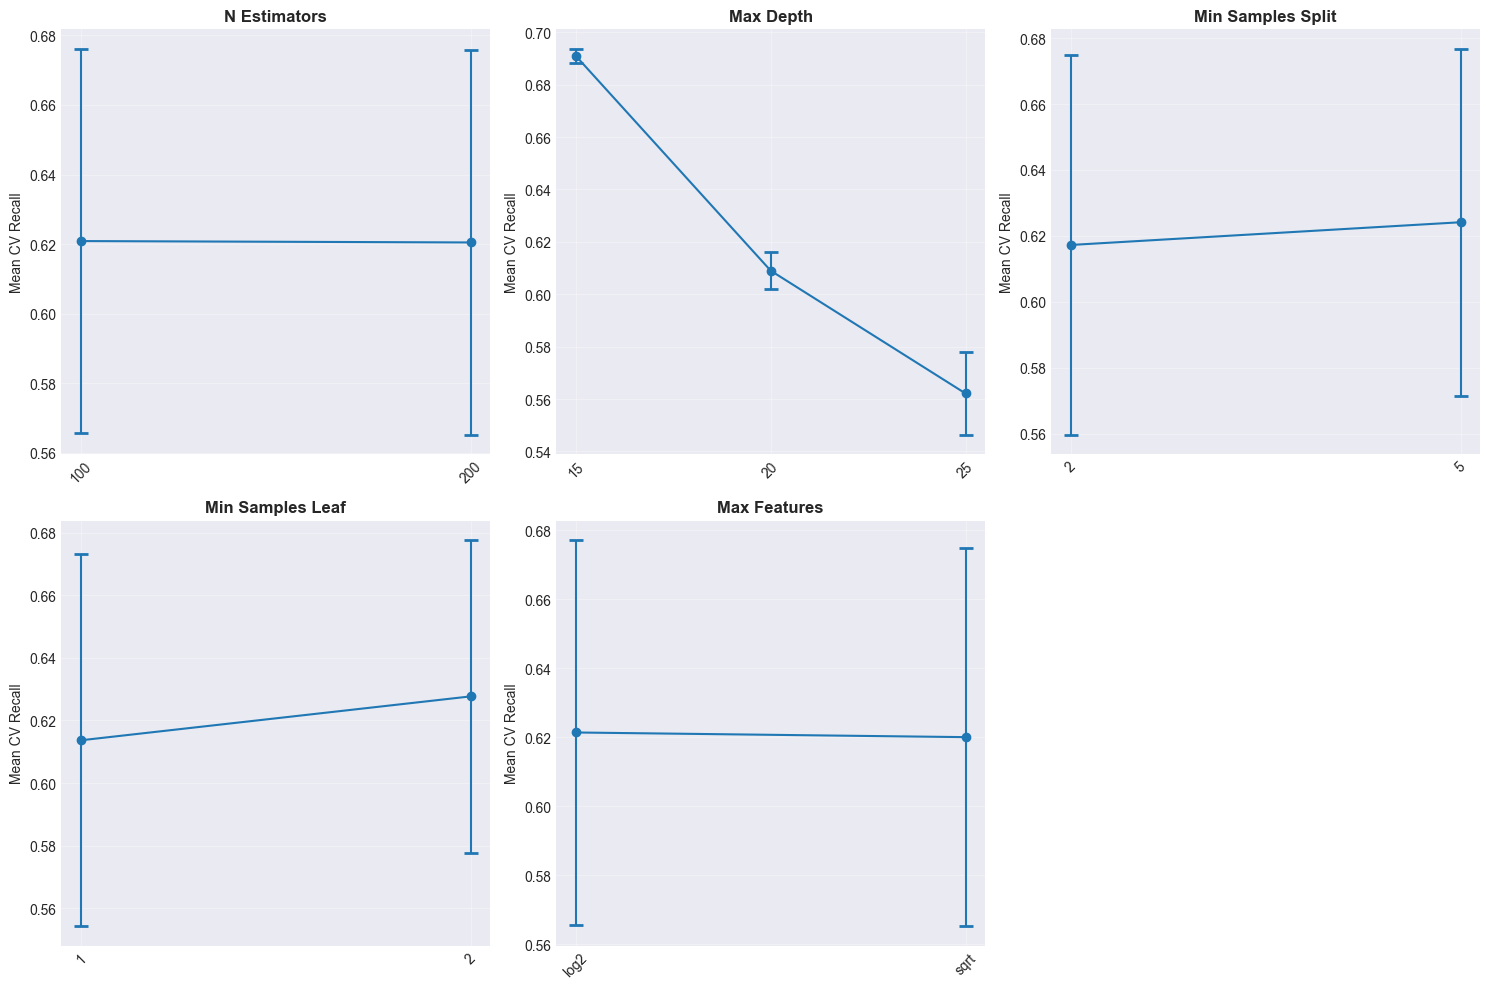

In [ ]:
# Get top 10 parameter combinations
cv_results = pd.DataFrame(grid_search.cv_results_)
top_results = cv_results.nsmallest(10, 'rank_test_score')[
    ['rank_test_score', 'mean_test_score', 'std_test_score', 
     'param_n_estimators', 'param_max_depth', 'param_min_samples_split',
     'param_min_samples_leaf', 'param_max_features']
]

print("\nTop 10 Parameter Combinations (by Recall):")
print(top_results.to_string(index=False))

# Visualize parameter importance
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

params_to_plot = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split',
                  'param_min_samples_leaf', 'param_max_features']

for idx, param in enumerate(params_to_plot):
    param_analysis = cv_results.groupby(param)['mean_test_score'].agg(['mean', 'std'])
    param_analysis = param_analysis.sort_index()
    
    axes[idx].errorbar(range(len(param_analysis)), param_analysis['mean'], 
                       yerr=param_analysis['std'], marker='o', capsize=5, capthick=2)
    axes[idx].set_xticks(range(len(param_analysis)))
    axes[idx].set_xticklabels(param_analysis.index, rotation=45)
    axes[idx].set_title(f'{param.replace("param_", "").replace("_", " ").title()}', 
                       fontweight='bold')
    axes[idx].set_ylabel('Mean CV Recall')
    axes[idx].grid(alpha=0.3)

# Hide the last subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## Analisis Hasil Hyperparameter Tuning

| Model | Accuracy | Precision | Recall | F1-Score | ROC-AUC |
|-------|----------|-----------|--------|----------|---------|
| **Baseline (11 features)** | 85.70% | 15.75% | **70.99%** | 25.78% | 87.23% |
| **Enhanced (~40 features)** | **94.77%** | **37.34%** | 72.90% | **49.39%** | **93.40%** |
| **Hyperparameter Tuned** | 94.49% | 36.01% | **73.94%** | 48.43% | 93.31% |

### Best Model for Random Forest Classifier: **Random Forest (Hyperparameter Tuned)**

**Alasan:**
1. Recall tertinggi (73.94%) - menangkap lebih banyak fraud
2. Trade-off minimal pada metrics lain
3. Optimal untuk fraud detection use case